In [1]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('..') # Add python files from main folder in PYTHON path
import utils
import DeepPatchMatch
%matplotlib inline

## Demo of PatchMatch with Pytorch on Images

This implementation is made to take 4 images as input for Deep Image Analogy

To see a demo on two images, just copy paste the same two images as 4 inputs and set `config['distance_mode'] = 'unidirectional'`

Row : 100
Row : 200
Row : 300
Row : 400
PatchMatch done!


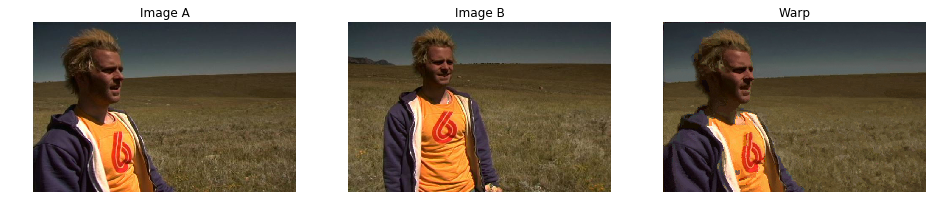

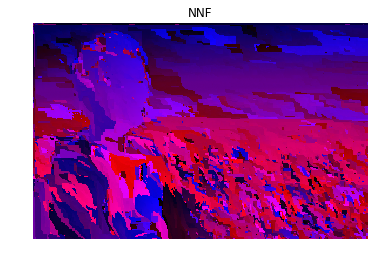

In [2]:
config = {}
config['patch_size'] = {1:5, 2:5, 3:3, 4:3, 5:3}
config['n_iter'] = 1
config['distance_mode'] = 'unidirectional' # 'unidirectional' or 'bidirectional'
config['random_search_max_step'] = {1:4, 2:4, 3:6, 4:6, 5:14} 

# Load the images
im1 = plt.imread(os.path.join("Images_for_tests", "image1.jpg"))
im2 = plt.imread(os.path.join("Images_for_tests", "image2.jpg"))

# Chagne images shape from [heigth, width, channels] to [channels, heigth, width]
imgs = [np.transpose(im1, axes=(2,0,1)), np.transpose(im2, axes=(2,0,1))]

# Turns them into autograd.Variables
imgs_torch = [Variable(torch.from_numpy(img).unsqueeze(0).float()) for img in imgs]

# Runs the PatchMatch algorithm
NNF_ab = DeepPatchMatch.computeNNF(imgs_torch[0], imgs_torch[1], imgs_torch[0], imgs_torch[1], 1, config)

# Reconverting NNF_ab to a ndarray of shape [heigth, width, channels]
NNF = np.transpose(NNF_ab.numpy(), axes=(1,2,0))

# Displays the original images and resulting Warp
plt.figure(figsize=(16, 12))
plt.subplot(131)
plt.imshow(im1)
plt.title("Image A")
plt.axis("off")

plt.subplot(132)
plt.imshow(im2)
plt.title("Image B")
plt.axis("off")

plt.subplot(133)
plt.imshow(im2[NNF[:,:,0], NNF[:,:,1], :])
plt.title("Warp")
plt.axis("off")
plt.show()

# Displays the NNF (mapping function)
zer = np.zeros(shape=(NNF.shape[0], NNF.shape[1], 1), dtype=NNF.dtype)
colorNNF = np.concatenate((np.expand_dims(NNF[:,:,0], 2), zer, np.expand_dims(NNF[:,:,1], 2)), axis=2)

plt.imshow(colorNNF.astype(np.uint8))
plt.title("NNF")
plt.axis("off")
plt.show()